In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch
import torch.nn.functional as F
import pandas as pd
import torchvision
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchmetrics.classification import MulticlassConfusionMatrix, F1Score, MulticlassPrecision, MulticlassRecall, MulticlassPrecisionRecallCurve, MulticlassROC
from torch.optim import lr_scheduler
import torch.nn as nn
import torch
import pytorch_lightning as pl
from torch.utils.tensorboard import SummaryWriter
from matplotlib.backends.backend_agg import FigureCanvasAgg

import confinement_mode_classifier as cmc
import alt_models as am


In [2]:
signal_window = 320
num_workers = 32
signal_name = 'mc'
batch_size = 512
pl.seed_everything(42)
path=os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
shot_usage = pd.read_csv(f'{path}/data/shot_usage.csv')
shot_for_ris = shot_usage[shot_usage['used_for_alt']]
shot_numbers = shot_for_ris['shot']

shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']
shots_for_training = shot_for_ris[shot_for_ris['used_as'] == 'train']['shot']


Seed set to 42


In [27]:
from importlib import reload
reload(am)

<module 'alt_models' from '/compass/Shared/Users/bogdanov/vyzkumny_ukol/alt_models.py'>

In [31]:
shot_df300, test_df300, val_df300, train_df300 = am.split_df(path, shot_numbers,shots_for_training, shots_for_testing, shots_for_validation, use_ELMS=True, signal_name=signal_name, sampling_freq=300)

In [36]:
train_dataloader300 = am.get_dloader(train_df300, batch_size=batch_size, 
                            balance_data=False, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)
val_dataloader300 = am.get_dloader(val_df300, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)


In [1]:
import torch

# Example soft labels list of lists
batch = {'label': [[0.05, 0.8, 0.15], [0.1, 0.7, 0.2], [0.2, 0.5, 0.3]]}

# Ensure device is correctly defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert the list of lists into a tensor, specifying the device during creation
labels_tensor = torch.tensor(batch['label'], dtype=torch.float).to(device)

print(labels_tensor)

tensor([[0.0500, 0.8000, 0.1500],
        [0.1000, 0.7000, 0.2000],
        [0.2000, 0.5000, 0.3000]], device='cuda:0')


In [40]:
import time 
from datetime import datetime
from pathlib import Path

dataloaders = {'train':train_dataloader300, 'val':val_dataloader300}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

untrained_model = am.select_model_architecture(architecture='Simple1DCNN', window=signal_window, 
                                               num_classes=3, in_channels=4)
untrained_model = untrained_model.to(device)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(untrained_model.parameters(), lr=0.001, weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=16) #!!!

timestamp =  datetime.fromtimestamp(time.time()).strftime("%y-%m-%d, %H-%M-%S ") + 'testing exponential elm decay'
writer = SummaryWriter(f'runs/{timestamp}')
model_path = Path(f'{path}/runs/{timestamp}/model.pt')

model = am.train_model(untrained_model, criterion, optimizer, exp_lr_scheduler, 
                    dataloaders, writer, dataset_sizes, num_epochs=2, 
                    chkpt_path = model_path.with_name(f'{model_path.stem}_best_val_acc{model_path.suffix}'),
                    signal_name=signal_name)

Epoch 1/2
----------


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/4178 [03:44<?, ?it/s]


KeyboardInterrupt: 

In [11]:
from importlib import reload
reload(am)

<module 'alt_models' from '/compass/Shared/Users/bogdanov/vyzkumny_ukol/alt_models.py'>

In [8]:
metrics = am.test_model(f'{path}/RIS1 preds for doubtful shots', untrained_model, 
                        train_dataloader300, max_batch=0, comment='', signal_name=signal_name, 
                        return_metrics=False)

Processing batches:   0%|          | 0/4178 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 4178/4178 [02:02<00:00, 34.14it/s]


In [10]:
metrics['prediction_df']

,shot,prediction,label,time,confidence,L_logit,H_logit,ELM_logit
0,16532,0,0,962.8500,0.703891,0.993609,-0.016735,-1.878489
1,16532,0,0,962.8535,0.703891,0.993609,-0.016735,-1.878489
2,16532,0,0,962.8570,0.703891,0.993609,-0.016735,-1.878489
3,16532,0,0,962.8605,0.703891,0.993609,-0.016735,-1.878489
4,16532,0,0,962.8640,0.703891,0.993609,-0.016735,-1.878489
...,...,...,...,...,...,...,...,...
2138813,19393,0,0,1261.2740,0.703891,0.993609,-0.016735,-1.878489
2138814,19393,0,0,1261.2775,0.703891,0.993609,-0.016735,-1.878489
2138815,19393,0,0,1261.2810,0.703891,0.993609,-0.016735,-1.878489
2138816,19393,0,0,1261.2845,0.703891,0.993609,-0.016735,-1.878489


In [13]:
shots_for_training_list = list(map(int,shots_for_training))
img_path = am.per_shot_test(path=f'{path}/RIS1 preds for doubtful shots', shots=shots_for_training, results_df=metrics['prediction_df'])
plt.close()

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:56<00:00,  1.94s/it]


In [4]:
shot_df300, test_df300, val_df300, train_df300 = am.split_df(path, shot_numbers,shots_for_training, shots_for_testing, shots_for_validation, use_ELMS=True, signal_name=signal_name, sampling_freq=300)
shot_df150, test_df150, val_df150, train_df150 = am.split_df(path, shot_numbers,shots_for_training, shots_for_testing, shots_for_validation, use_ELMS=True, signal_name=signal_name, sampling_freq=150)
shot_df30, test_df30, val_df30, train_df30 = am.split_df(path, shot_numbers,shots_for_training, shots_for_testing, shots_for_validation, use_ELMS=True, signal_name=signal_name, sampling_freq=30)

train_dataloader300 = am.get_dloader(train_df300, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

train_dataloader30 = am.get_dloader(train_df30, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

train_dataloader150 = am.get_dloader(train_df150, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

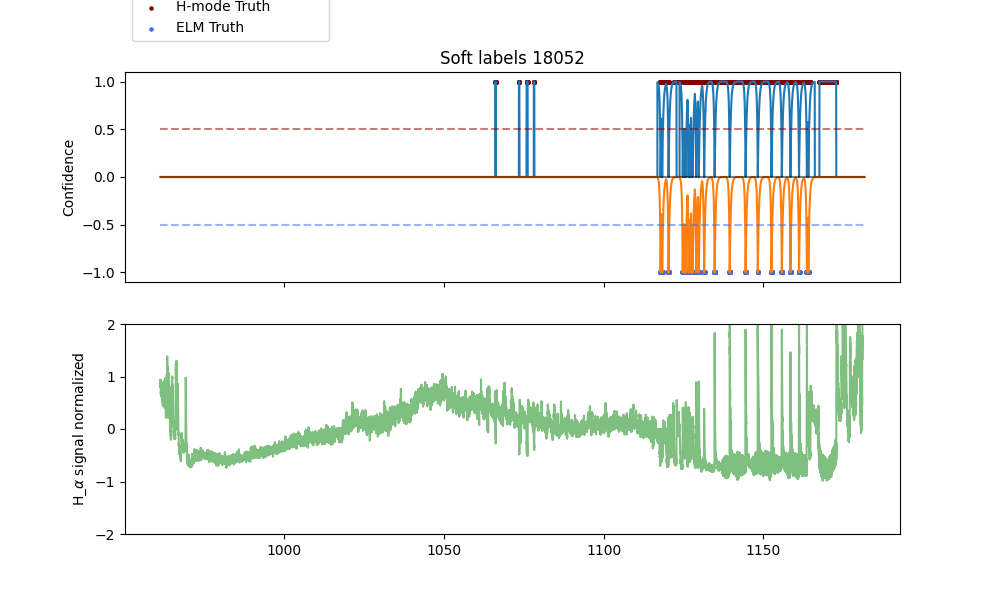

In [32]:
shot = 18052
%matplotlib widget

dummy_df = shot_df300[shot_df300['shot']==18052]
probs_modes = np.stack(dummy_df['soft_label'].to_numpy())

h_alpha = pd.read_csv(f'{path}/data/h_alpha_signal_{300}kHz/shot_{shot}.csv')
signals_df = pd.read_csv(f'{path}/data/mirnov_coil_signal_{300}kHz/shot_{shot}.csv')
#norming h_alpha
h_alpha['h_alpha'] = (h_alpha['h_alpha'] - h_alpha['h_alpha'].mean())/h_alpha['h_alpha'].std()


# these are matplotlib.patch.Patch properties
df_merged = pd.merge_asof(dummy_df, h_alpha, on='time', tolerance=1/300, direction='nearest')


conf_time_fig, conf_time_ax = plt.subplots(2,1, sharex=True, 
                                           figsize=(10,6))
conf_time_ax[0].plot(df_merged['time'],probs_modes[:,1], label='H-mode ground truth')
conf_time_ax[0].plot(df_merged['time'],-probs_modes[:,2], label='ELM ground truth')
conf_time_ax[0].scatter(df_merged[df_merged['mode_x']==1]['time'], 
                  len(df_merged[df_merged['mode_x']==1])*[1], 
                  s=5, alpha=1, label='H-mode Truth', color='maroon')
        
conf_time_ax[0].scatter(df_merged[df_merged['mode_x']==2]['time'], 
                  len(df_merged[df_merged['mode_x']==2])*[-1], 
                  s=5, alpha=1, label='ELM Truth', color='royalblue')
conf_time_ax[0].set_title(f'Soft labels {shot}')
conf_time_ax[0].hlines(0, df_merged['time'].min(), df_merged['time'].max(), color='black', alpha=0.5, linestyle='-')
conf_time_ax[0].hlines(0.5, df_merged['time'].min(), df_merged['time'].max(), color='maroon', alpha=0.5, linestyle='--')
conf_time_ax[0].hlines(-0.5, df_merged['time'].min(), df_merged['time'].max(), color='royalblue', alpha=0.5, linestyle='--')
conf_time_ax[0].set_ylabel('Confidence')
conf_time_ax[0].legend(loc='upper left', bbox_to_anchor=(0,1.6))


conf_time_ax[1].set_ylabel(r'H_$\alpha$ signal normalized')
conf_time_ax[1].set_ylim(-2, 2)
conf_time_ax[1].plot(df_merged['time'],df_merged['h_alpha'].values, label='H_alpha', color='green', alpha=0.5)

